In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from cs109.dataloader import build_dataset
from cs109.dataloader import load_news

from cs109.model import KNNAnomalyDetector

%matplotlib inline

### Detecting anomaly in MSFT stock price

In [2]:
msft_data = build_dataset()

In [3]:
news_data = load_news()

In [4]:
sec_data = pd.read_csv("datasets/sec_filings.csv", parse_dates=[0])
sec_data = sec_data.set_index('Date')

In [5]:
def plot_results(data, dates, results, threshold):    
    fig = plt.figure(figsize=(14, 5)) 

    concept_channge_dates = dates[results[:, 3] == 1.0]
    conspet_channge_points = data[results[:, 3] == 1.0, 0]
    
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(dates, data[:, 0], 'b-')
    ax1.scatter(concept_channge_dates, conspet_channge_points, marker = 'o', color = 'r', s=100)
    ax1.set_ylabel('Adj Close', color='b')
    ax1.set_title('Concept changes marked as red dots')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    for i, txt in enumerate(concept_channge_dates):
        ax1.annotate(txt.date(), (concept_channge_dates[i], conspet_channge_points[i]))

    ax2 = ax1.twinx()
    ax2.plot(dates, results[:, 2], 'g.')
    ax2.set_ylabel('Martingale', color='g')
    for tl in ax2.get_yticklabels():
        tl.set_color('g')
    return concept_channge_dates

In [6]:
# show news on 'date' and up to 'days_before' days before
def show_news(date, days_before = 7):
    pd.set_option('display.max_colwidth', -1)
    start = date
    end = date - dt.timedelta(days = days_before)
    return news_data[(news_data.index <= start) & (news_data.index >= end)]

In [7]:
# show MSFT data on 'date' and up to 'days_before' days before
def show_data(date, days_before = 7):
    start = date
    end = date - dt.timedelta(days = days_before)
    d = msft_data[(msft_data.index <= start) & (msft_data.index >= end)]
    return d.iloc[: , 0 : 11]

In [8]:
# show SEC filings on 'date' and up to 'days_before' days before
def show_documents(date, days_before = 7):
    start = date
    end = date - dt.timedelta(days = days_before)
    d = sec_data[(sec_data.index <= start) & (sec_data.index >= end)]
    return d.iloc[: , 0 : 10]

### Analysing last 120 days of MSFT stock

In [9]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))

results = np.array(results)

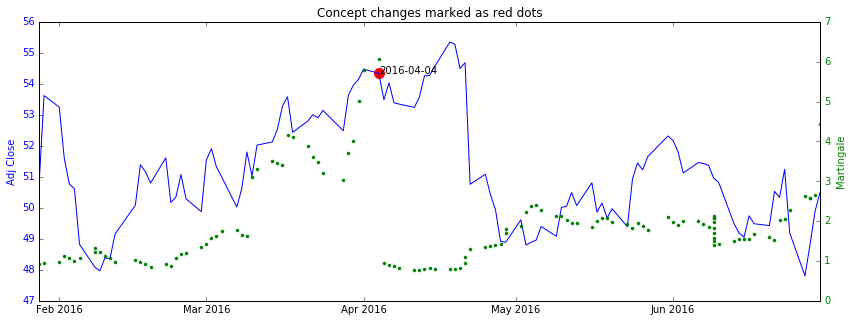

In [10]:
concept_change_dates = plot_results(X, D, results, threshold)

#### Stock data on and up to 7 days before the concept change date

In [11]:
show_data(concept_change_dates[0])

,Adj Close,Diluted EPS,Gross Margin,Operating Income,Revenue,SP500,DFF,DGS10,NASDAQ100,Acquisition,Investment
2016-03-28,52.484233,0.62,13924.0,6026.0,23796.0,2037.05,0.37,1.89,4398.07,0.0,0.0
2016-03-29,53.631159,0.62,13924.0,6026.0,23796.0,2055.01,0.37,1.81,4467.72,0.0,0.0
2016-03-30,53.964455,0.62,13924.0,6026.0,23796.0,2063.95,0.37,1.83,4490.88,0.0,0.0
2016-03-31,54.140906,0.47,12809.0,5283.0,20531.0,2059.74,0.25,1.78,4483.66,0.0,0.0
2016-04-01,54.474201,0.47,12809.0,5283.0,20531.0,2072.78,0.37,1.79,4532.08,0.0,0.0
2016-04-04,54.336963,0.47,12809.0,5283.0,20531.0,2066.13,0.37,1.78,4511.70,0.0,0.0


Based on the martingale anomaly detection model, a concept change is detected on April 22 2016. At this point, the martingale value is higher than a predefined threshold (6.0). The date when anomaly is reported is consistent with the date when a significant close price drop occurs on April 22 2016. There is no significant delay on this detection.

In [12]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.92

concept_change_dates_list=[]

for i in range (10):
    results = []

    detector = KNNAnomalyDetector(
        n_neighbors = n_neighbors, 
        epsilon = epsilon,
        threshold = threshold
    )

    msft = msft_data.as_matrix()
    X = msft[-days_to_analyse:]
    D = msft_data.index.date[-days_to_analyse:]

    for x in X:
        results.append(detector.observe(x))
    
    results = np.array(results)
    
    for d in D[results[:, 3] == 1.0]:
        concept_change_dates_list.append(d)

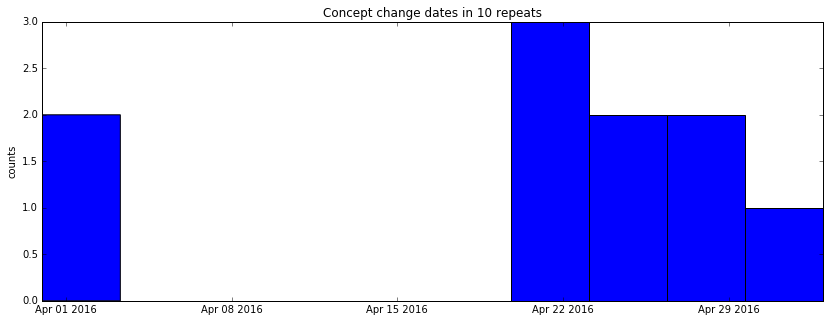

In [13]:
fig = plt.figure(figsize=(14, 5)) 
ax = fig.add_subplot(1, 1, 1)
h = ax.hist(concept_change_dates_list)
ax.set_xlabel('')
ax.set_ylabel('counts')
ax.set_title('Concept change dates in 10 repeats')

If the martingale analysis was performed multiple times, a slightly different concept change date would be reported (charts for each repeats not shown). In a 10-time-repeat experiment, the resulting concept change dates range from April 1 to April 29, with the highest frequency in April 22. 

The uncertain part in martingale-base anomaly detection is $\theta$, which is randomly chosen from $[0, 1]$ when calculating p. A smaller $\theta$ will result in a lower p value and a higher martingale value. Anomaly status of data points that has a martingale value around the threshold can easily be affected by the value of $\theta$.

#### News and SEC filings on and up to 7 days before the concept change date

In [14]:
show_news(concept_change_dates[0])

,Headline
Date,
2016-04-02 12:34:00,Time Inc. (TIME) weighs partnering with private equity for Yahoo bid -- Reuters
2016-03-31 21:58:00,WSJ's Heard on the Street column continues down warpath against trusting non-GAAP results
2016-03-31 14:00:00,"Microsoft announces cloud services, developer tools and productivity extensions for every developer"
2016-03-31 12:18:00,StreetAccount Summary: The Economist print edition
2016-03-30 20:22:00,WSJ's Heard on the Street column says Microsoft needs to connect with smartphone developers
2016-03-30 15:19:00,Twitter - @MSFTnews: Microsoft outlines intelligence vision and announces new innovations for #Windows10 at #Build2016 https://t.co/FbbqkH2Ulg
2016-03-30 14:00:00,DJ Saab: Saab and Microsoft HoloLens Working to Redefine the Training and Education Experience
2016-03-30 13:40:00,Rackspace shares trading higher
2016-03-30 13:30:00,Microsoft outlines intelligence vision and announces new innovations for Windows 10


In [15]:
show_documents(concept_change_dates[0])

,Filing,Description
Date,,
2016-04-02,4,Statement of Changes of Beneficial Ownership


After reviewing the news and SEC filings on or up to 7 days before the concept change date, we found that on April 21 2016, Microsoft announced the Third Quarter Results, which included a 6% decline in fiscal third-quarter revenue to 20.5 billion and  earnings of 3.8 billion which fell 25% year over year. This event is likely to be the causal factor inducing the stock price drop on April 22 2016.

There are two parameters in our model, $\epsilon$ and n_neighbors, can affect whether a data point would be classified as anomaly or not. In the above analysis, n_neighbors $= 5$ and $\epsilon = 0.92$ were used as default parameter values. Next, different parameter values are tried on Microsoft data.

##### Anomaly detection with a incresed $\epsilon = 0.95$

In [16]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.94

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

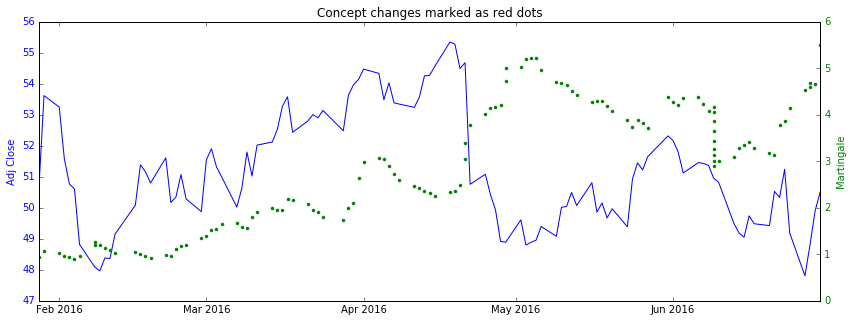

In [17]:
concept_change_dates = plot_results(X, D, results, threshold)

##### Anomaly detection with a decreased $\epsilon = 0.89$

In [18]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.89

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

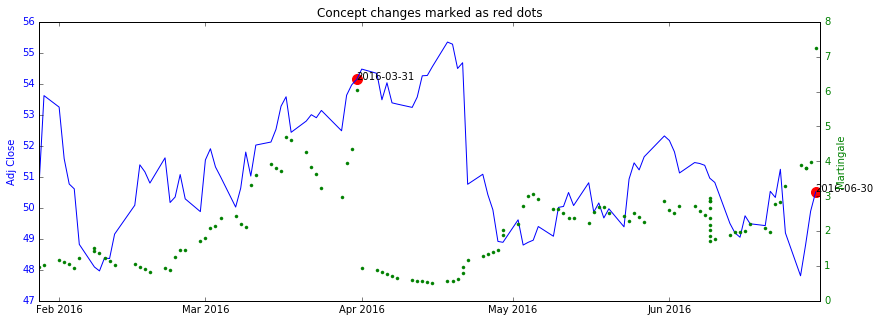

In [19]:
concept_change_dates = plot_results(X, D, results, threshold)

Even a slight change on the value of $\epsilon$ will lead to a significant change in the martingale, and then affect the decision on anomaly detection. Observation in Microsoft stock data shows that lower $\epsilon$ leads to a more sensitive model, tending to classify a certain data point as anomaly, and vice versa. Increase model sensitivity would lead to higher false positive rate while decreased model sensitivity would lead to higher false negative rate.

##### Anomaly detection with a increased n_neighbors $= 8$

In [20]:
days_to_analyse = 120
n_neighbors = 8 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

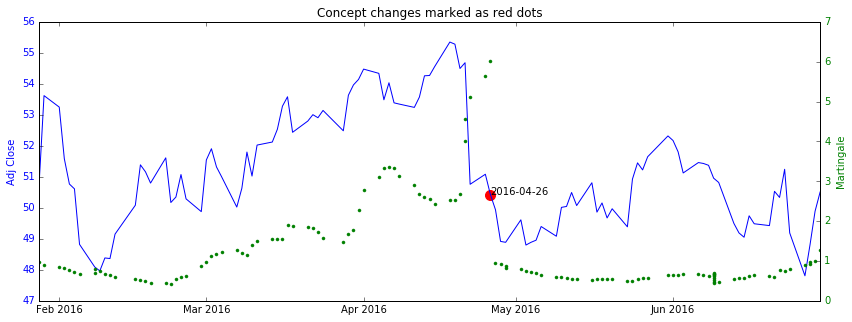

In [21]:
concept_change_dates = plot_results(X, D, results, threshold)

##### Anomaly detection with a decreased n_neighbors $= 3$

In [22]:
days_to_analyse = 120
n_neighbors = 3 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

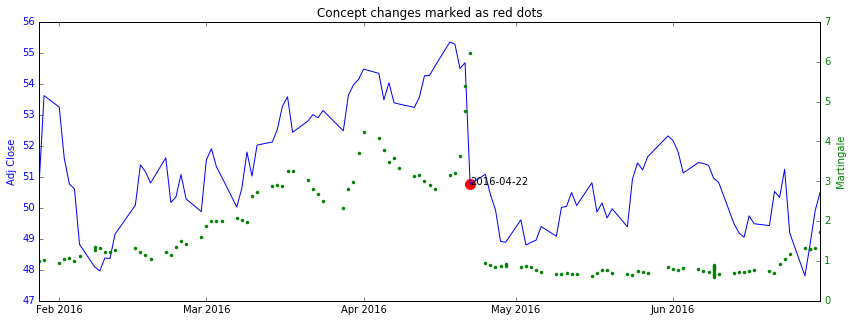

In [23]:
concept_change_dates = plot_results(X, D, results, threshold)

Alteration on n_neighbors does not have a major influence on martingale values.

In practical applications, the values of these two parameters need to be chosen carefully. In our analysis on Microsoft stock data, the default value of n_neighbors $= 5$ and $\epsilon = 0.92$ seems to be reasonable regarding both accuracy and delay time.

### Analysing last 360 days of MSFT stock

In [24]:
days_to_analyse = 360
n_neighbors = 5 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

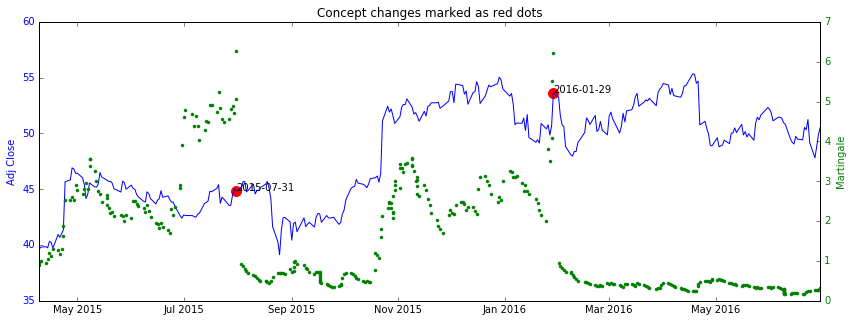

In [25]:
concept_change_dates = plot_results(X, D, results, threshold)

Two concept change dates were reported in the past 260 days.

#### Concept change date No.1 on July 1 2015
#### Stock data on and up to 7 days before the concept change date

In [26]:
show_data(concept_change_dates[0])

,Adj Close,Diluted EPS,Gross Margin,Operating Income,Revenue,SP500,DFF,DGS10,NASDAQ100,Acquisition,Investment
2015-07-24,44.122740,-0.4,14712.0,-2053.0,22180.0,2079.65,0.13,2.27,4557.37,0.0,0.0
2015-07-27,43.556079,-0.4,14712.0,-2053.0,22180.0,2067.64,0.14,2.23,4519.09,0.0,0.0
2015-07-28,43.546476,-0.4,14712.0,-2053.0,22180.0,2093.25,0.14,2.26,4560.23,0.0,0.0
2015-07-29,44.458897,-0.4,14712.0,-2053.0,22180.0,2108.57,0.14,2.29,4581.60,0.0,0.0
2015-07-30,45.025559,-0.4,14712.0,-2053.0,22180.0,2108.63,0.14,2.28,4598.59,0.0,0.0
2015-07-31,44.852679,-0.4,14712.0,-2053.0,22180.0,2103.84,0.08,2.20,4588.91,0.0,0.0
2015-07-31,44.852679,-0.4,14712.0,-2053.0,22180.0,2103.84,0.08,2.20,4588.91,0.0,0.0


#### News and SEC filings on and up to 7 days before the concept change date

In [27]:
show_news(concept_change_dates[0])

,Headline
Date,
2015-07-30 16:29:00,"Dir GATES III Sells 2,000,000 of MICROSOFT CORP (MSFT)"
2015-07-29 16:28:00,"Dir GATES III Sells 2,000,000 of MICROSOFT CORP (MSFT)"
2015-07-29 00:00:00,Windows 10 available in 190 countries as a free upgrade
2015-07-28 17:58:00,"COO TURNER Sells 69,158 of MICROSOFT CORP (MSFT)"
2015-07-27 05:00:00,Allview présente ses premiers appareils Windows 10
2015-07-27 05:00:00,Allview präsentiert seine ersten Geräte für Windows 10
2015-07-25 17:12:00,Barron's Summary


In [28]:
show_documents(concept_change_dates[0])

,Filing,Description
Date,,
2015-07-31,4,Statement of Changes of Beneficial Ownership
2015-07-31,10-K,Annual Report
2015-07-30,4,Statement of Changes of Beneficial Ownership
2015-07-29,4,Statement of Changes of Beneficial Ownership
2015-07-28,4,Statement of Changes of Beneficial Ownership


The stock price dropping starts on June 29 and the anomaly reported date is on July 1, suggesting a slight delay in this anomaly report. The stock price anomaly might be associated with the "Annual Report of Employee Stock Purchase" announced a few days before (on June 24).

#### Concept change date No.1 on February 2 2016
#### Stock data on and up to 7 days before the concept change date

In [29]:
show_data(concept_change_dates[1])

,Adj Close,Diluted EPS,Gross Margin,Operating Income,Revenue,SP500,DFF,DGS10,NASDAQ100,Acquisition,Investment
2016-01-22,50.893473,0.62,13924.0,6026.0,23796.0,1906.90,0.38,2.07,4259.77,0.0,0.0
2016-01-25,50.406827,0.62,13924.0,6026.0,23796.0,1877.08,0.38,2.03,4196.53,0.0,0.0
2016-01-26,50.776676,0.62,13924.0,6026.0,23796.0,1903.63,0.38,2.01,4233.85,0.0,0.0
2016-01-27,49.852051,0.62,13924.0,6026.0,23796.0,1882.95,0.38,2.02,4128.86,0.0,0.0
2016-01-28,50.669617,0.62,13924.0,6026.0,23796.0,1893.36,0.38,2.00,4186.06,0.0,0.0
2016-01-28,50.669617,0.62,13924.0,6026.0,23796.0,1893.36,0.38,2.00,4186.06,0.0,0.0
2016-01-29,53.618692,0.62,13924.0,6026.0,23796.0,1940.24,0.29,1.94,4279.17,0.0,0.0


#### News and SEC filings on and up to 7 days before the concept change date

In [30]:
show_news(concept_change_dates[1])

,Headline
Date,
2016-01-28 23:36:00,"CORRECTED TRANSCRIPT: Microsoft Corp.(MSFT-US), Q2 2016 Earnings Call, 28-January-2016 5:30 PM ET"
2016-01-28 22:58:00,WSJ's Heard on the Street column is cautious on Microsoft's cloud success
2016-01-28 18:07:00,Microsoft provides Q3 (Mar) guidance -- conf. call
2016-01-28 16:45:00,Microsoft Reports Second Quarter 2016 Results
2016-01-28 16:30:00,MICROSOFT CORP Investor Slides: Q2 2016 Earnings
2016-01-28 16:21:00,Twitter - @MSFTnews: Microsoft Cloud strength highlights second quarter results https://t.co/P1YErLpreh
2016-01-28 16:17:00,StreetAccount Metrics Recap - Microsoft Q2 Earnings
2016-01-28 16:14:00,"MICROSOFT CORP files (10-Q) Basic quarterly filing, for period end 31-Dec-15 (MSFT-US)"
2016-01-28 16:14:00,Microsoft Corp: 10-Q FactSet Blackline Report for period ending 12/31/2015


In [31]:
show_documents(concept_change_dates[1])

,Filing,Description
Date,,
2016-01-28,10-Q,Quarterly Report
2016-01-28,8-K,Current Report
2016-01-26,SC 13G/A,Amended Statement of Beneficial Ownership


The stock price dropping starts on January 28 and the anomaly reported date is on February 02, suggesting a slight delay in this anomaly report. The stock price anomaly might be associated with the "Microsoft 2Q Earnings" report announced a few days before (on January 28). 